mainly looking at https://github.com/ngessert/isic2019/blob/master/models.py

# start

In [1]:
PRFX = 'MelPrp0626A1'

# setup

In [2]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [12]:
p_cmp = '../input/siim-isic-melanoma-classification'
p_19 = '../input/andrewmvd--isic-2019'
p_out=f'../output/{PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)

train,test,sample_submission = (pd.read_csv(o) for o in [f'{p_cmp}/{o}.csv' 
                                                         for o in ('train', 'test', 'sample_submission')])
print([o.shape for o in (train,test,sample_submission)])

train19 = pd.read_csv(f'{p_19}/ISIC_2019_Training_GroundTruth.csv')
print(train19.shape)

display(train19.head(2))
display(train.head(2))

test.head(2)

[(33126, 8), (10982, 5), (10982, 2)]
(25331, 10)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity


# prep

## merge dfs

In [4]:
train['source'] = '20'
train['im_pth'] = f'{p_cmp}/jpeg/train/'+train.image_name+'.jpg'
train19['source'] = '19'
train19['target'] = train19.MEL
train19['im_pth'] = f'{p_19}/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'+train19.image+'.jpg'


In [5]:
cols2use=['source', 'im_pth', 'target', ]
train_all = pd.concat([train[cols2use], train19[cols2use]])
display(train_all.shape)
display(train_all.source.value_counts())
display(train_all.groupby('source').target.mean())

(58457, 3)

20    33126
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017630
Name: target, dtype: float64

## load images

CPU times: user 12.5 ms, sys: 27 µs, total: 12.5 ms
Wall time: 22.9 ms


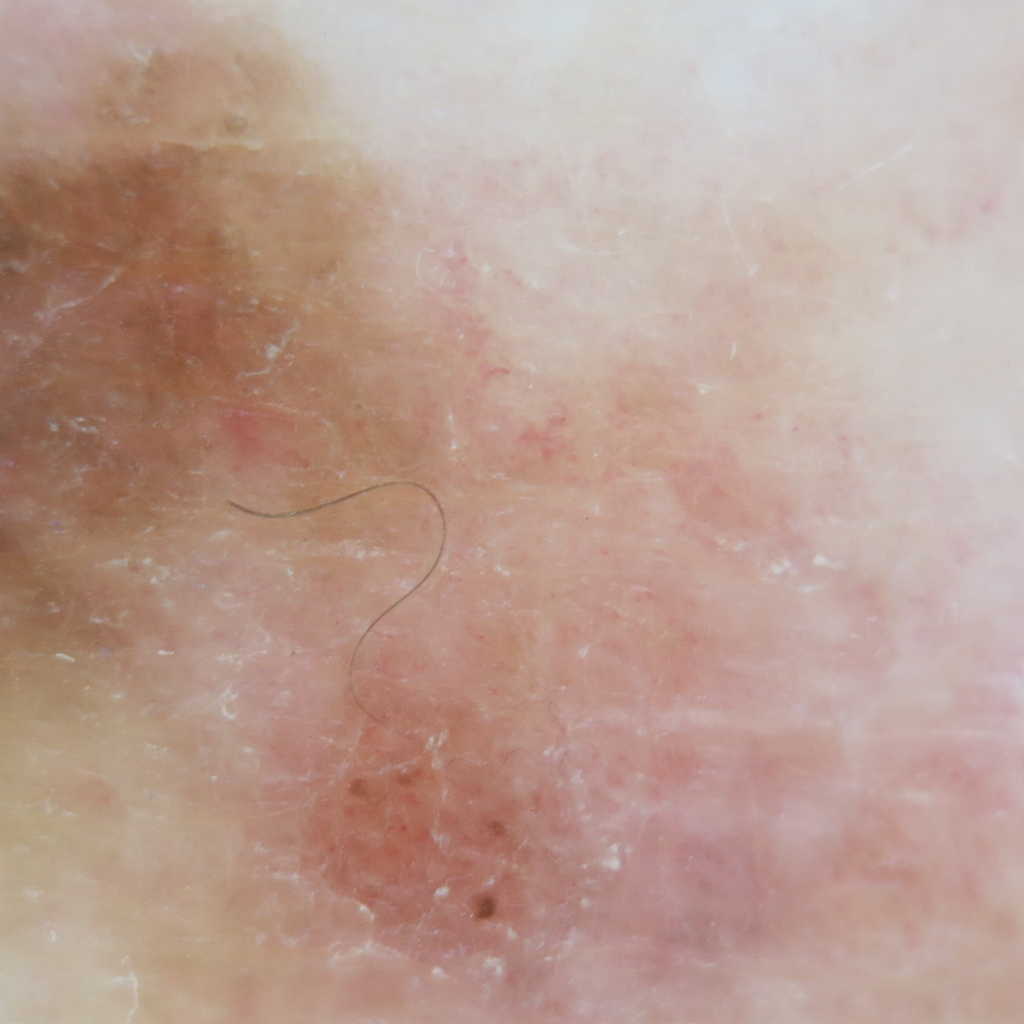

In [6]:
%%time
im_pil = Image.open(train_all.im_pth.sample().values[0])
im_pil

In [7]:
lst_im_pil = []
for im_pth in tqdm(train_all.im_pth):
    lst_im_pil.append(Image.open(im_pth))

100%|██████████| 58457/58457 [00:18<00:00, 3090.43it/s]


In [8]:
sys.getsizeof(lst_im_pil)

514576

### faster to preload images

In [9]:
i = np.random.choice(range(len(train_all)))

In [10]:
%%timeit 
im_pil = Image.open(train_all.im_pth.values[i])

263 µs ± 75.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%%timeit 
im_pil = lst_im_pil[i]

210 ns ± 27.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
